# Discover Symmetry of Rotation (Training)

## Import packages & Mount Drive

In [1]:
import torch as tch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# from google.colab import drive
# import os, sys

# drive.mount('/content/mnt')
# nb_path = '/content/notebooks'
# os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0, nb_path)

In [3]:
#!ls drive/My\ Drive/Colab\ Notebooks

In [4]:
device = 'cuda' if tch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
pi = tch.tensor(math.pi).float().to(device)
pi

tensor(3.1416)

## Play with Data

In [6]:
# Rotation Data
unif1 = Uniform(0.1, 1)
unif2 = Uniform(0, 2*math.pi)
r = unif1.sample([1000,]).float().to(device)
th = unif2.sample([1000,]).float().to(device)
X = tch.column_stack([r*tch.cos(th), r*tch.sin(th)])
X

tensor([[ 0.2370, -0.3475],
        [-0.2526, -0.9085],
        [ 0.6871,  0.5287],
        ...,
        [-0.0032, -0.2016],
        [ 0.1635, -0.4683],
        [-0.5317,  0.1071]])

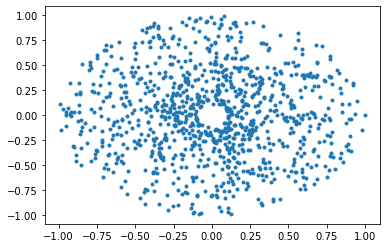

In [7]:
plt.plot(X[:,0].cpu(), X[:,1].cpu(), '.')

In [8]:
# Generate Positive pair
unif = Uniform(0, 2*math.pi)
thetas = unif.sample([1000,]).to(device)
X_p = tch.column_stack([r*tch.cos(th+thetas), r*tch.sin(th+thetas)])
X_p

tensor([[-0.3489,  0.2349],
        [-0.9150,  0.2282],
        [ 0.5593, -0.6624],
        ...,
        [ 0.1264,  0.1570],
        [-0.4758,  0.1404],
        [ 0.1170,  0.5296]])

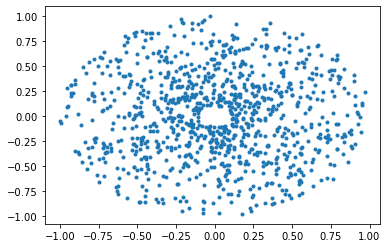

In [9]:
plt.plot(X_p[:,0].cpu(), X_p[:,1].cpu(), '.')

In [10]:
# Generate Negative pair
unif1 = Uniform(0.1, 1)
unif2 = Uniform(0, 2*math.pi)
r = unif1.sample([1000,]).float().to(device)
th = unif2.sample([1000,]).float().to(device)
X_n = tch.column_stack([r*tch.cos(th), r*tch.sin(th)])
X_n

tensor([[-0.0557,  0.3168],
        [ 0.5903,  0.3949],
        [-0.7495, -0.1647],
        ...,
        [-0.4885,  0.0686],
        [-0.3010, -0.0068],
        [-0.1341, -0.1233]])

In [11]:
X_n

tensor([[-0.0557,  0.3168],
        [ 0.5903,  0.3949],
        [-0.7495, -0.1647],
        ...,
        [-0.4885,  0.0686],
        [-0.3010, -0.0068],
        [-0.1341, -0.1233]])

In [12]:
# Labeling
y_p = tch.zeros((X_p.shape[0], 1))
y_n = tch.ones((X_n.shape[0], 1))
y = tch.vstack([y_p, y_n])
y

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

## Implement Dataset

In [13]:
# Implement Dataset
class RotationDataset(Dataset):
    def __init__(self, size):
        unif1 = Uniform(0.1, 1)
        unif2 = Uniform(0, 2*math.pi)
        unif3 = Uniform(0.1, 1)
        unif4 = Uniform(0, 2*math.pi)
        unif5 = Uniform(0, 2*math.pi)

        r1 = unif1.sample([size]).float()
        th1 = unif2.sample([size]).float()
        r2 = unif3.sample([size]).float()
        th2 = unif4.sample([size]).float()
        th3 = unif5.sample([size]).float()

        self.X = tch.column_stack([r1*tch.cos(th1), r1*tch.sin(th1)])
        X_p = tch.column_stack([r1*tch.cos(th1+th3), r1*tch.sin(th1+th3)])
        X_n = tch.column_stack([r2*tch.cos(th2), r2*tch.sin(th2)])

        self.X = tch.vstack([self.X, self.X])
        self.X_pair = tch.vstack([X_p, X_n])

        # Labeling
        y_p = tch.zeros((X_p.shape[0], 1))
        y_n = tch.ones((X_n.shape[0], 1))
        self.y = tch.vstack([y_p, y_n])

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = tch.Tensor(self.X[idx])
        x_pair = tch.Tensor(self.X_pair[idx])
        y = tch.Tensor(self.y[idx])
        return x, x_pair, y

## Implement Siamese Network

In [14]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.linear_relu = nn.Sequential(
            nn.Linear(2,100),
            nn.ReLU(),
            nn.Linear(100,1),
            nn.ReLU()
        )

    def forward(self, x1, x2):
        out1 = self.linear_relu(x1)
        out2 = self.linear_relu(x2)
        return out1, out2

## Implement Contrastive Loss (Hadsell)

In [15]:
class ContrastiveLoss(tch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = tch.mean((1-label) * tch.pow(euclidean_distance, 2) +
                                      (label) * tch.pow(tch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

## Declare Model, Loss and Optimizer

In [16]:
net = SNN().to(device)
print(net)

SNN(
  (linear_relu): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): ReLU()
  )
)


In [17]:
loss_fn = ContrastiveLoss()
optimizer = tch.optim.Adam(net.parameters(), lr=0.01)
scheduler = tch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

## Make Dataset & Dataloader

In [18]:
train_dataset = RotationDataset(100000)
valid_dataset = RotationDataset(10000)
test_dataset = RotationDataset(10000)

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=500)
test_dataloader = DataLoader(test_dataset, batch_size=500)

In [20]:
for _, samples in enumerate(test_dataloader):
    x, x_p, y = samples
    temp = tch.column_stack([x, x_p, y])
    print(temp[:5, :])
    break

tensor([[ 0.6654,  0.6933, -0.4201, -0.8642,  0.0000],
        [-0.1052,  0.1358, -0.1718, -0.0015,  0.0000],
        [-0.0764,  0.2834,  0.0137, -0.2932,  0.0000],
        [ 0.0399, -0.1757, -0.1591,  0.0846,  0.0000],
        [-0.5722, -0.4753,  0.4422, -0.5981,  0.0000]])


## Train & Validate

In [21]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = []
    for batch, samples in enumerate(dataloader):
        X, X_p, y = samples
        X, X_p, y = X.to(device), X_p.to(device), y.to(device)

        pred1, pred2 = model(X, X_p)
        loss = loss_fn(pred1, pred2, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * X.shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            train_loss.append(loss)
        
    return tch.mean(tch.tensor(train_loss).float().to(device))

In [22]:
def validity_check(dataloader, model, loss_fn, dist=1):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with tch.no_grad():
        for X, X_p, y in dataloader:
            X, X_p, y = X.to(device), X_p.to(device), y.to(device)
            pred1, pred2 = model(X, X_p)
            test_loss += loss_fn(pred1, pred2, y).item()
            correct += tch.count_nonzero((tch.abs(pred1 - pred2) <= dist) != y).item()
    test_loss /= num_batches
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    # print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [23]:
epochs = 500
train_loss= []
valid_loss = []
lr = 0.01
for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    train_loss.append(train(train_dataloader, net, loss_fn, optimizer))
    validity, correct = validity_check(valid_dataloader, net, loss_fn, 0.2)
    valid_loss.append(validity)
    scheduler.step(validity)
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        print(f" Learning Rate: {lr:>8f}")
    if lr < 1e-6:
        break
    if correct == 1:
        break
print("Done!")


Epoch 1
-------------------------------
loss: 1.853884  [    0/200000]
loss: 0.567444  [50000/200000]
loss: 0.179092  [100000/200000]
loss: 0.150117  [150000/200000]
Validation Error: 
 Accuracy: 95.2%, Avg loss: 0.126005
 Learning Rate: 0.010000

Epoch 2
-------------------------------
loss: 0.082890  [    0/200000]
loss: 0.167598  [50000/200000]
loss: 0.090190  [100000/200000]
loss: 0.113316  [150000/200000]
Validation Error: 
 Accuracy: 96.8%, Avg loss: 0.089933
 Learning Rate: 0.010000

Epoch 3
-------------------------------
loss: 0.103200  [    0/200000]
loss: 0.091275  [50000/200000]
loss: 0.089410  [100000/200000]
loss: 0.107282  [150000/200000]
Validation Error: 
 Accuracy: 97.5%, Avg loss: 0.075371
 Learning Rate: 0.010000

Epoch 4
-------------------------------
loss: 0.044586  [    0/200000]
loss: 0.057282  [50000/200000]
loss: 0.095808  [100000/200000]
loss: 0.071192  [150000/200000]
Validation Error: 
 Accuracy: 97.8%, Avg loss: 0.062324
 Learning Rate: 0.010000

Epoch 5

loss: 0.021824  [50000/200000]
loss: 0.021638  [100000/200000]
loss: 0.027004  [150000/200000]
Validation Error: 
 Accuracy: 99.1%, Avg loss: 0.031752
 Learning Rate: 0.010000

Epoch 35
-------------------------------
loss: 0.041981  [    0/200000]
loss: 0.024236  [50000/200000]
loss: 0.029173  [100000/200000]
loss: 0.049364  [150000/200000]
Validation Error: 
 Accuracy: 99.2%, Avg loss: 0.026881
 Learning Rate: 0.010000

Epoch 36
-------------------------------
loss: 0.027402  [    0/200000]
loss: 0.046173  [50000/200000]
loss: 0.035029  [100000/200000]
loss: 0.049959  [150000/200000]
Validation Error: 
 Accuracy: 99.2%, Avg loss: 0.025828
 Learning Rate: 0.010000

Epoch 37
-------------------------------
loss: 0.025729  [    0/200000]
loss: 0.027385  [50000/200000]
loss: 0.037223  [100000/200000]
loss: 0.052168  [150000/200000]
Validation Error: 
 Accuracy: 99.2%, Avg loss: 0.023793
 Learning Rate: 0.010000

Epoch 38
-------------------------------
loss: 0.022577  [    0/200000]
loss

loss: 0.015210  [50000/200000]
loss: 0.022411  [100000/200000]
loss: 0.012435  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.022234
 Learning Rate: 0.010000

Epoch 68
-------------------------------
loss: 0.024934  [    0/200000]
loss: 0.012116  [50000/200000]
loss: 0.026687  [100000/200000]
loss: 0.029811  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.022412
 Learning Rate: 0.010000

Epoch 69
-------------------------------
loss: 0.030997  [    0/200000]
loss: 0.008694  [50000/200000]
loss: 0.049617  [100000/200000]
loss: 0.026689  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.019472
 Learning Rate: 0.010000

Epoch 70
-------------------------------
loss: 0.020451  [    0/200000]
loss: 0.037423  [50000/200000]
loss: 0.008677  [100000/200000]
loss: 0.012657  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.021183
 Learning Rate: 0.010000

Epoch 71
-------------------------------
loss: 0.032687  [    0/200000]
loss

loss: 0.011467  [50000/200000]
loss: 0.031734  [100000/200000]
loss: 0.037993  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.016476
 Learning Rate: 0.001000

Epoch 101
-------------------------------
loss: 0.021758  [    0/200000]
loss: 0.028821  [50000/200000]
loss: 0.028003  [100000/200000]
loss: 0.035996  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.016166
 Learning Rate: 0.001000

Epoch 102
-------------------------------
loss: 0.022580  [    0/200000]
loss: 0.010179  [50000/200000]
loss: 0.006135  [100000/200000]
loss: 0.029029  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.016178
 Learning Rate: 0.001000

Epoch 103
-------------------------------
loss: 0.006460  [    0/200000]
loss: 0.007335  [50000/200000]
loss: 0.023903  [100000/200000]
loss: 0.002714  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.016109
 Learning Rate: 0.001000

Epoch 104
-------------------------------
loss: 0.003774  [    0/200000]


loss: 0.036658  [50000/200000]
loss: 0.020092  [100000/200000]
loss: 0.030040  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.015947
 Learning Rate: 0.001000

Epoch 134
-------------------------------
loss: 0.030501  [    0/200000]
loss: 0.013017  [50000/200000]
loss: 0.020084  [100000/200000]
loss: 0.014046  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.015755
 Learning Rate: 0.001000

Epoch 135
-------------------------------
loss: 0.002532  [    0/200000]
loss: 0.010706  [50000/200000]
loss: 0.015252  [100000/200000]
loss: 0.023472  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.016426
 Learning Rate: 0.001000

Epoch 136
-------------------------------
loss: 0.019158  [    0/200000]
loss: 0.011875  [50000/200000]
loss: 0.023581  [100000/200000]
loss: 0.030218  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.015774
 Learning Rate: 0.001000

Epoch 137
-------------------------------
loss: 0.013836  [    0/200000]


loss: 0.026600  [50000/200000]
loss: 0.012721  [100000/200000]
loss: 0.036667  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.015507
 Learning Rate: 0.001000

Epoch 167
-------------------------------
loss: 0.025027  [    0/200000]
loss: 0.021132  [50000/200000]
loss: 0.004975  [100000/200000]
loss: 0.020915  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.015456
 Learning Rate: 0.001000

Epoch 168
-------------------------------
loss: 0.010791  [    0/200000]
loss: 0.019194  [50000/200000]
loss: 0.005682  [100000/200000]
loss: 0.006655  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.015245
 Learning Rate: 0.001000

Epoch 169
-------------------------------
loss: 0.012641  [    0/200000]
loss: 0.012119  [50000/200000]
loss: 0.012553  [100000/200000]
loss: 0.019237  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.015811
 Learning Rate: 0.001000

Epoch 170
-------------------------------
loss: 0.015271  [    0/200000]


loss: 0.021786  [50000/200000]
loss: 0.016135  [100000/200000]
loss: 0.024561  [150000/200000]
Validation Error: 
 Accuracy: 99.5%, Avg loss: 0.014827
 Learning Rate: 0.000100

Epoch 200
-------------------------------
loss: 0.013170  [    0/200000]
loss: 0.011286  [50000/200000]
loss: 0.015030  [100000/200000]
loss: 0.003888  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.014940
 Learning Rate: 0.000100

Epoch 201
-------------------------------
loss: 0.015586  [    0/200000]
loss: 0.012340  [50000/200000]
loss: 0.025242  [100000/200000]
loss: 0.020861  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.014832
 Learning Rate: 0.000100

Epoch 202
-------------------------------
loss: 0.009073  [    0/200000]
loss: 0.033981  [50000/200000]
loss: 0.039880  [100000/200000]
loss: 0.010146  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.014772
 Learning Rate: 0.000100

Epoch 203
-------------------------------
loss: 0.022668  [    0/200000]


loss: 0.013443  [50000/200000]
loss: 0.009460  [100000/200000]
loss: 0.027571  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.014714
 Learning Rate: 0.000010

Epoch 233
-------------------------------
loss: 0.011122  [    0/200000]
loss: 0.037575  [50000/200000]
loss: 0.009768  [100000/200000]
loss: 0.035577  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.014713
 Learning Rate: 0.000010

Epoch 234
-------------------------------
loss: 0.009230  [    0/200000]
loss: 0.020719  [50000/200000]
loss: 0.029479  [100000/200000]
loss: 0.033006  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.014712
 Learning Rate: 0.000010

Epoch 235
-------------------------------
loss: 0.022412  [    0/200000]
loss: 0.012585  [50000/200000]
loss: 0.012161  [100000/200000]
loss: 0.024281  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.014703
 Learning Rate: 0.000010

Epoch 236
-------------------------------
loss: 0.005935  [    0/200000]


loss: 0.008044  [50000/200000]
loss: 0.010266  [100000/200000]
loss: 0.005318  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.014699
 Learning Rate: 0.000001

Epoch 266
-------------------------------
loss: 0.011722  [    0/200000]
loss: 0.019958  [50000/200000]
loss: 0.010413  [100000/200000]
loss: 0.017031  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.014698
 Learning Rate: 0.000001

Epoch 267
-------------------------------
loss: 0.017824  [    0/200000]
loss: 0.013582  [50000/200000]
loss: 0.019326  [100000/200000]
loss: 0.011036  [150000/200000]
Validation Error: 
 Accuracy: 99.4%, Avg loss: 0.014700
 Learning Rate: 0.000000
Done!


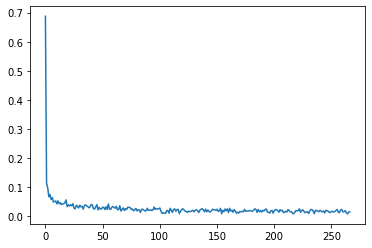

In [24]:
plt.plot(train_loss)

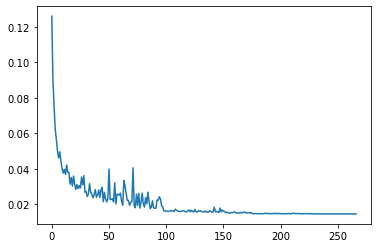

In [25]:
plt.plot(valid_loss)

## Print Result & Save Model

In [26]:
with tch.no_grad():
    for X, X_p, y in test_dataloader:
        X, X_p, y = X.to(device), X_p.to(device), y.to(device)
        pred1, pred2 = net(X, X_p)
        data = tch.column_stack([pred1, pred2, y])
        print(data[:10,:])
        break

tensor([[170.0760, 170.2173,   0.0000],
        [ 30.3589,  30.3620,   0.0000],
        [ 51.9403,  51.9227,   0.0000],
        [ 31.8383,  31.8406,   0.0000],
        [131.7257, 131.7486,   0.0000],
        [ 37.8560,  37.8360,   0.0000],
        [ 54.9689,  54.9670,   0.0000],
        [144.6526, 144.7256,   0.0000],
        [122.1455, 122.1345,   0.0000],
        [ 86.0924,  86.1150,   0.0000]])


In [27]:
tch.save(net, "model/snn_rot7.pt")